# EDA: basic

- Descriptive analysis.
- Causality between two numerical variables.

In [13]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.datasets import load_iris
import pandas as pd
import numpy as np
from scipy.stats import kurtosis
from scipy.stats import skew

## load data

In [2]:
# load dataset
dataset = load_iris()
dataset.keys()
# dataset to df
data = pd.DataFrame(dataset.data, columns = dataset.feature_names)
data['class'] = dataset.target
dclass = dict()
for i, ic in enumerate(dataset.target_names):
    dclass[i] = ic
data['class'] = data['class'].map(dclass)

## df format

In [3]:
# check what columns are NUMERICAL or CATEGORICAL
cols_num = data.select_dtypes(include=['float64', 'int64']).columns.values  # numerical columns
cols_cat = data.select_dtypes(include=['object']).columns.values            # categorical columns
# columns name converters: numerical
dcols_num_name_to_alias = dict()
dcols_num_alias_to_name = dict()
for i, ic in enumerate(cols_num):
    dcols_num_name_to_alias[ic] = 'n{}'.format(i)
    dcols_num_alias_to_name['n{}'.format(i)] = ic
# columns name converters: categorical
dcols_cat_name_to_alias = dict()
dcols_cat_alias_to_name = dict()
for i, ic in enumerate(cols_cat):
    dcols_cat_name_to_alias[ic] = 'c{}'.format(i)
    dcols_cat_alias_to_name['c{}'.format(i)] = ic
# rename columns
data.rename(columns = dcols_num_name_to_alias, inplace = True)
data.rename(columns = dcols_cat_name_to_alias, inplace = True)
# list of alias
cols_num_alias = list(dcols_num_name_to_alias.values())
cols_cat_alias = list(dcols_cat_name_to_alias.values())

# descriptive analysis

### numerical

In [4]:
# describe
dfn = data[cols_num_alias].describe(include = 'all', percentiles = [.05, .25, .5, .75, .95]).T
# add percent of nan values
dfn['%nan'] = (data[cols_num_alias].isnull().sum()*100 / len(data)).values
# kurtosis
dfn['kurtosis'] = kurtosis(data[cols_num_alias])
# skew
dfn['skew'] = skew(data[cols_num_alias])
# rename index
dfn.index = dfn.index.map(dcols_num_alias_to_name)
dfn

,count,mean,std,min,5%,25%,50%,75%,95%,max,%nan,kurtosis,skew
sepal length (cm),150.0,5.843333,0.828066,4.3,4.600,5.1,5.80,6.4,7.255,7.9,0.0,-0.573568,0.311753
sepal width (cm),150.0,3.057333,0.435866,2.0,2.345,2.8,3.00,3.3,3.800,4.4,0.0,0.180976,0.315767
petal length (cm),150.0,3.758000,1.765298,1.0,1.300,1.6,4.35,5.1,6.100,6.9,0.0,-1.395536,-0.272128
petal width (cm),150.0,1.199333,0.762238,0.1,0.200,0.3,1.30,1.8,2.300,2.5,0.0,-1.336067,-0.101934


### categorical

In [5]:
# describe
dfc = data[cols_cat_alias].describe(include = 'all').T[['count', 'unique']]
# add percent of nan values
dfc['%nan'] = (data[cols_cat_alias].isnull().sum()*100 / len(data)).values

In [6]:
## add categories percenets

# maximum number of categories to be showed
max_size_cats = 5
# set columns
col_temp = ['var'] + ['value{}'.format(i) for i in range(max_size_cats)] + ['%value{}'.format(i) for i in range(max_size_cats)]
# initialize
values_temp = list()
# loop of variables
for col in cols_cat_alias:
    # count categories
    temp = data[col].value_counts(normalize=True,sort=True,ascending=False)*100.
    # collect values and names
    c = temp.index.values
    v = temp.values
    # resize
    if len(v) > max_size_cats:
        v = np.append(v[:max_size_cats-1], np.sum(v[-(max_size_cats):]))
        c = np.append(c[:max_size_cats-1], 'others')
    else:
        v = np.pad(v,(0, max_size_cats-len(v)), 'constant', constant_values=np.nan)
        c = np.pad(c,(0, max_size_cats-len(c)), 'constant', constant_values=np.nan)
    # append    
    values_temp.append([col] + list(np.append(c,v)))
# add new information
dfc = pd.concat([dfc, pd.DataFrame(values_temp, columns = col_temp).set_index('var')], axis = 1)
# rename index
dfc.index = dfc.index.map(dcols_cat_alias_to_name)
dfc

,count,unique,%nan,value0,value1,value2,value3,value4,%value0,%value1,%value2,%value3,%value4
var,,,,,,,,,,,,,
class,150,3,0.0,setosa,versicolor,virginica,NaN,NaN,33.333333,33.333333,33.333333,NaN,NaN


# causality

Ver si el aumento de una variable provoca un aumento/disminucion regular de la otra variable mediante la distribuciones de pendientes.

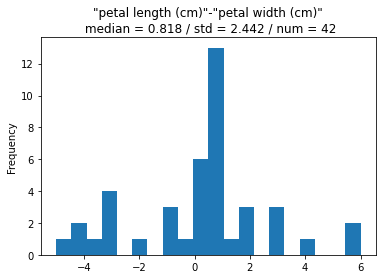

In [48]:
# columns selection
x1_col = cols_num_alias[2]
x2_col = cols_num_alias[3]
# collect data
df = data[[x1_col, x2_col]]
# descending sort of the first column
df.sort_values(x1_col, inplace = True)
# calculate difference between rows
df = df.diff(axis = 0).dropna()
# calculate sloples
df['slope'] = df[x2_col] / df[x1_col]
# remove inf values
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace = True)
# plot histogram
stitle = '"{}"-"{}"\n median = {:.3f} / std = {:.3f} / num = {}'.format(dcols_num_alias_to_name[x1_col], 
                                                                       dcols_num_alias_to_name[x2_col], 
                                                                       np.median(df.slope.values), 
                                                                       np.std(df.slope.values), 
                                                                       len(df.slope.values))
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
df.slope.plot(kind = 'hist', bins = 20, title = stitle)
plt.show()